In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def values(func, left, right, n):
    return func(np.linspace(left, right, n))

Функции, которые работают:

In [79]:
def wtt_filter(input_vector, d, modes, ranks, check_correctness=False):
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
    
    return filters

In [80]:
def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [81]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

In [82]:
modes = [2] * d
ranks = [2] * (d - 1)

filters = wtt_filter(
    sqrt_x_values,
    d,
    modes,
    ranks,
    True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)

Пайплайн для счёта общей матрицы преобразования $W$:

In [83]:
W = filters[-1].T
I = np.eye(modes[-1])
for k in range(d - 2, -1, -1):
    r = ranks[k]
    r_prev = 1 if k == 0 else ranks[k - 1]
    m = modes[k]

    assert I.shape[0] == I.shape[1] == np.prod(modes[k + 1:])
    
    E = np.eye(r_prev * m, r) 

    R = filters[k][:,:r]
    assert np.allclose(R, filters[k] @ E)

    P = filters[k] * np.array(
        [0.] * r + [1.] * (m * r_prev - r)
    )
    assert np.allclose(P, filters[k] @ (np.eye(r_prev * m) - E @ E.T))
    
    W = np.kron(I, E) @ W @ np.kron(I, R.T) + np.kron(I, P.T)
    I = np.kron(np.eye(m), I)

TODO: возможно, крону с единичной матрицей можно ускорить.

В отличие от статьи, надо поменять порядок в кронах. Стандартная крона:
$$
A \otimes B =
\begin{pmatrix}
a_{11} B & \ldots & a_{1n}B \\
\vdots & \ddots & \vdots \\
a_{m1} B & \ldots & a_{mn}B \\
\end{pmatrix}
$$

Индексы бегают быстрее из $B$, потом --- из $A$. Но раз в той же статье мы хотим $$W_{i_1,...,i_k; j_1,...,j_k} = V^{(1)}_{i_1,j_1} \ldots V^{(k)}_{i_k,k_k} \Rightarrow W = V_1 \otimes \ldots \otimes V_k$$, а запись $W_{i_1,...,i_k; j_1,...,j_k}$ подразумевает, что левые индексы меняются быстро, правые --- медленно (Fortran порядок), то крона должна действовать не как обычно. В общем, при кроне у левой матрицы индексы должны меняться быстро, у правой --- медленно.

In [84]:
W.shape

(1024, 1024)

In [85]:
assert np.allclose(W @ sqrt_x_values, wtt_res)

Как я понимаю, базисные функции --- строки итоговой матрицы (м.б. с нормированием):

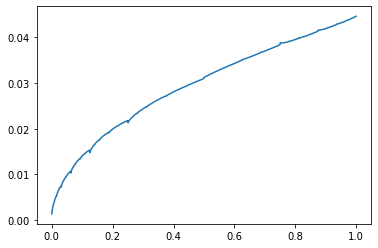

In [86]:
plt.plot(linspace, W[0,:])

Ага, форма такая, но граничные значения разнятся.

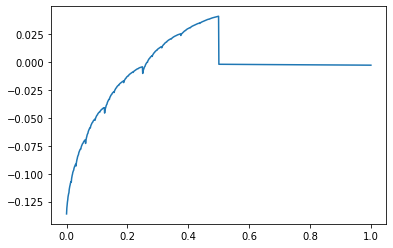

In [87]:
plt.plot(linspace, W[1,:])

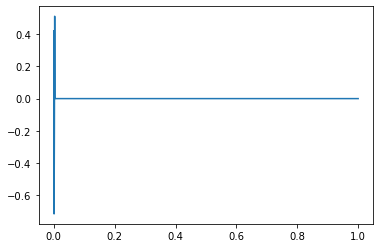

In [88]:
plt.plot(linspace, W[2,:])

Коэффициенты для корня:

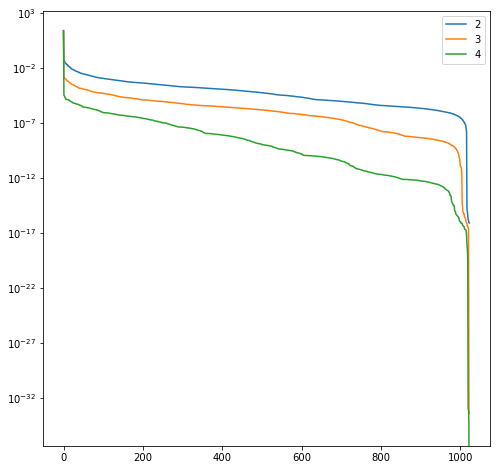

In [89]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)
sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

wtt_coefs_sqrt = []
for r in [2, 3, 4]:
    modes = [2] * d
    ranks = [2] + [r] * (d - 2)

    filters = wtt_filter(
        sqrt_x_values,
        d,
        modes,
        ranks,
        True
    )
    wtt_res = wtt_apply(
        sqrt_x_values,
        d,
        filters,
        modes,
        ranks,
        True
    )
    wtt_coefs_sqrt.append(np.flip(np.sort(np.abs(wtt_res))))
    
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d), wtt_coefs_sqrt[i], label=str(r))
plt.yscale('log')
plt.legend()

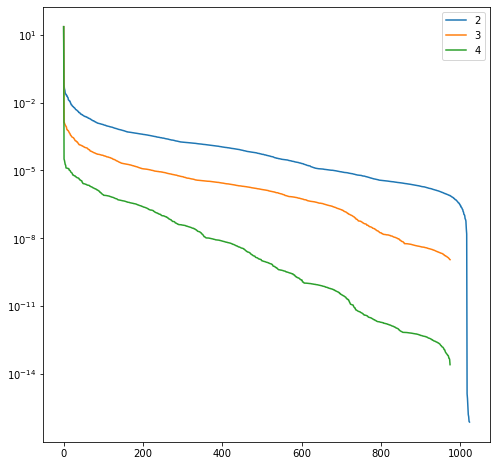

In [90]:
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    if r == 2:
        plt.plot(np.arange(2 ** d), wtt_coefs_sqrt[i], label=str(r))
    else:
        plt.plot(np.arange(2 ** d)[:975], wtt_coefs_sqrt[i][:975], label=str(r))
plt.yscale('log')
plt.legend()

Базисные функции для синуса:

In [91]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sin_sq_values = values(lambda x: np.sin(500 * x ** 2), left, right, n)

In [92]:
modes = [2] * d
ranks = [2] * (d - 1)

filters = wtt_filter(
    sin_sq_values,
    d,
    modes,
    ranks,
    True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)

In [93]:
W = filters[-1].T
I = np.eye(modes[-1])
for k in range(d - 2, -1, -1):
    r = ranks[k]
    r_prev = 1 if k == 0 else ranks[k - 1]
    m = modes[k]

    assert I.shape[0] == I.shape[1] == np.prod(modes[k + 1:])
    
    E = np.eye(r_prev * m, r) 

    R = filters[k][:,:r]
    assert np.allclose(R, filters[k] @ E)

    P = filters[k] * np.array(
        [0.] * r + [1.] * (m * r_prev - r)
    )
    assert np.allclose(P, filters[k] @ (np.eye(r_prev * m) - E @ E.T))
    
    W = np.kron(I, E) @ W @ np.kron(I, R.T) + np.kron(I, P.T)
    I = np.kron(np.eye(m), I)

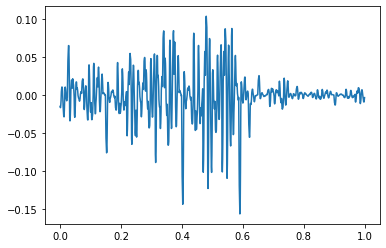

In [94]:
plt.plot(linspace, W[0,:])

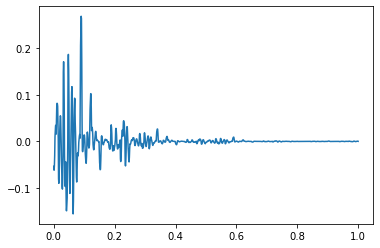

In [95]:
plt.plot(linspace, W[1,:])

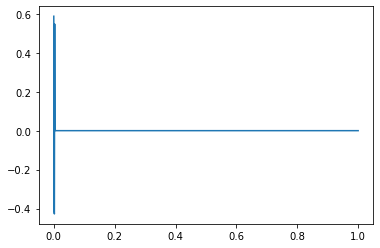

In [96]:
plt.plot(linspace, W[2,:])

Коэффициенты для синуса:

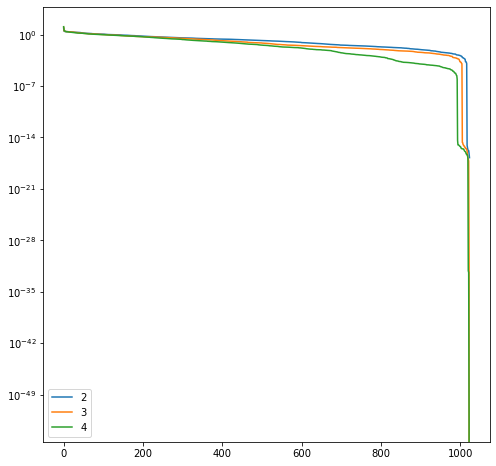

In [97]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)
sin_sq_values = values(lambda x: np.sin(500 * x ** 2), left, right, n)

wtt_coefs_sin_sq = []
for r in [2, 3, 4]:
    modes = [2] * d
    ranks = [2] + [r] * (d - 2)

    filters = wtt_filter(
        sin_sq_values,
        d,
        modes,
        ranks,
        True
    )
    wtt_res = wtt_apply(
        sin_sq_values,
        d,
        filters,
        modes,
        ranks,
        True
    )
    wtt_coefs_sin_sq.append(np.flip(np.sort(np.abs(wtt_res))))
    
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d), wtt_coefs_sin_sq[i], label=str(r))
plt.yscale('log')
plt.legend()

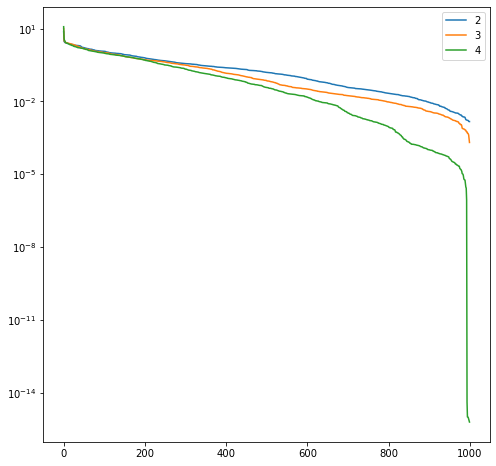

In [98]:
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d)[:1000], wtt_coefs_sin_sq[i][:1000], label=str(r))
plt.yscale('log')
plt.legend()

$\varepsilon$-стратегия:

Обрезаем сингулярные числа, которые меньше $\varepsilon$. То есть ошибка в 2-норме $< \varepsilon$. Возможно, они обрезают так, чтобы сумма квадратов оставшихся была меньше $\varepsilon^2$ (и, соответственно, ошибка в норме Фробениуса $< \varepsilon$).

Сделаю общий вариант (можно задавать ранги приближения и/или $\varepsilon$: если задано и то, и другое, то итоговым рангом берётся минимум из двух получающихся рангов).

In [104]:
def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert eps > 0
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else ranks[k]
        r_eps = None if eps is None else max(1, np.where(sigmas >= eps)[0].size)
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

In [107]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

modes = [2] * d
eps = 1e-4
filters, true_ranks = wtt_filter(sqrt_x_values, d, modes, eps=eps, check_correctness=True)
print(true_ranks)

[2, 4, 4, 4, 4, 4, 4, 4, 2]


Посмотрим, есть ли отличие из-за избыточных рангов в конце ($\varepsilon$-стратегия говорит, что в конце можно взять ранг 2, а не 4).

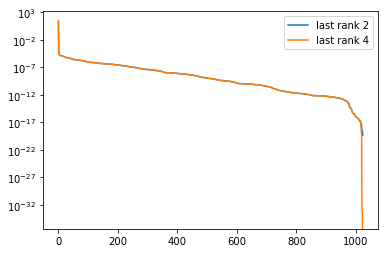

In [113]:
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    true_ranks,
    True
)
plt.plot(np.arange(2 ** d), np.flip(np.sort(np.abs(wtt_res))), label='last rank 2')
#[2,4,...,4,2]
plt.plot(np.arange(2 ** d), wtt_coefs_sqrt[-1], label='last rank 4')
#[2,4,...,4]
plt.yscale('log')
plt.legend()

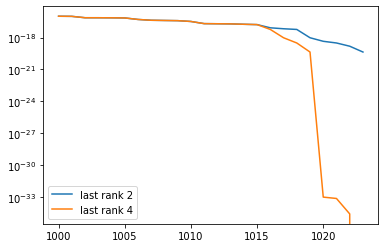

In [115]:
plt.plot(np.arange(2 ** d)[1000:], np.flip(np.sort(np.abs(wtt_res)))[1000:], label='last rank 2')
#[2,4,...,4,2]
plt.plot(np.arange(2 ** d)[1000:], wtt_coefs_sqrt[-1][1000:], label='last rank 4')
#[2,4,...,4]
plt.yscale('log')
plt.legend()

In [114]:
np.linalg.norm(np.flip(np.sort(np.abs(wtt_res))) - wtt_coefs_sqrt[-1])

8.374873881648556e-18

Только в самых-самых маленьких есть разница (по абсолютной величине совсем незначительная).

Сверим также, как себя ведёт $\varepsilon$-стратегия в плане памяти. Сверимся со статьёй 2011 года.

In [130]:
d = 20
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sin_x_values = values(lambda x: np.sin(100 * x), left, right, n)

modes = [2] * d

In [132]:
epsilons = [10 ** (-4 - 2 * i) for i in range(5)]
print(epsilons)

for eps in epsilons:
    print("eps=", eps)
    filters, true_ranks = wtt_filter(sin_x_values, d, modes, eps=eps, check_correctness=True)
    wtt_result = wtt_apply(sin_x_values, d, filters, modes, true_ranks, True)
    #NNZ
    print(wtt_result[0]) 
    print(np.allclose(wtt_result[1:], np.zeros(wtt_result.size - 1)))
    #ранги = 2
    print(true_ranks)
    
    memory_for_filters = 0
    for u in filters:
        memory_for_filters += u.size
    print(memory_for_filters)

[0.0001, 1e-06, 1e-08, 1e-10, 1e-12]
eps= 0.0001
725.6562012962519
True
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-06
725.6562012962519
True
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-08
725.6562012962519
True
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-10
725.6562012962519
True
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-12
725.6562012962527
True
[2, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2]
600


Не совсем так, как в статье...

Во-первых, memory не 152: по идее, у нас одна матрица 2 на 2 и 19 матриц 4 на 4 с рангом 2, поэтому нам надо 308 ячеек памяти для хранения...

In [133]:
print(2 * 2 + 19 * 4 * 4)

308


Во-вторых, при $\varepsilon = 10^{-12}$ уже начинаются всякие численные странности (округление проваливается).

Применение вейвлетов в 2d: как я понимаю, надо решейпнуть матрицу $2^d \times 2^d$ в $2 \times \ldots \times 2$, затем попереставлять индексы и снова решейпнуть.

In [168]:
def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

In [169]:
def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

In [170]:
d = 5
n = 2 ** d
A = np.random.rand(n, n)
modes = [2] * d

v, new_modes = matrix_to_vector(A, d, modes, True)
assert new_modes == [4] * d

A_changed, modes_changed = vector_to_matrix(v, d, new_modes, True)
assert np.all(A_changed == A)
assert modes_changed == modes

Применение WTT к матрице: переход к вектору, обычное WTT, переход обратно к матрице.

In [175]:
d_range = np.arange(5, 12)
eps = 10 ** (-8)

for d in d_range:
    print("d =", d)
    n = 2 ** d
    A = np.fromfunction(
        lambda i, j: 1./(i - j),
        (n, n)
    )
    A[np.arange(n), np.arange(n)] = 0
    
    matrix_modes = [2] * d
    v, vector_modes = matrix_to_vector(A, d, matrix_modes)
    
    filters, true_ranks = wtt_filter(v, d, vector_modes, eps=eps)
    wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
    wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)
    
    print(np.sum(np.isclose(wtt_A, 0)))
    memory_for_filters = 0
    for u in filters:
        memory_for_filters += u.size
    print(memory_for_filters)

d = 5
1023
1872
d = 6
4095
3808
d = 7
16383
5744
d = 8
65535
8048
d = 9
262143
10720
d = 10


C:\Users\kdi20\AppData\Local\Temp/ipykernel_3304/1674531096.py:8: RuntimeWarning: divide by zero encountered in true_divide
  lambda i, j: 1./(i - j),


1048575
13024
d = 11
4194303
15328


Диск:

In [196]:
d = 9
n = 2 ** d
distances = np.fromfunction(
    lambda i, j: (i - n / 2) ** 2 + (j - n / 2) ** 2,
    (n, n)
)
A = np.ones((n, n))
A[distances <= n ** 2 / 4] = 2
matrix_modes = [2] * d

In [202]:
eps = 10**(-2)
v, vector_modes = matrix_to_vector(A, d, matrix_modes)
    
filters, true_ranks = wtt_filter(v, d, vector_modes, eps=eps)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

262143
[4, 16, 64, 116, 61, 29, 13, 4]
937.9344326763988


In [203]:
eps = 10**(-4)
v, vector_modes = matrix_to_vector(A, d, matrix_modes)
    
filters, true_ranks = wtt_filter(v, d, vector_modes, eps=eps)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

262143
[4, 16, 64, 116, 61, 29, 13, 4]
937.9344326763988
